In [712]:
from align_depth_permeability_util import *

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [713]:
data_dir = '../data/'

X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(data_dir)
X_train.shape

/Users/hadrianfung/ads-arcadia-reservoirrocks/notebooks
/Users/hadrianfung/ads-arcadia-reservoirrocks/notebooks
No permeability label for 204-19-3a
No permeability label for 204-19-6
/Users/hadrianfung/ads-arcadia-reservoirrocks/notebooks
/Users/hadrianfung/ads-arcadia-reservoirrocks/notebooks


(563, 30)

## EDA 

### Check missing values

In [384]:
X_train.isna().sum()

index                               0
DEPTH                               0
SAMPLE_NUMBER                      13
PERMEABILITY(VERTICAL)_Kair_md    416
POROSITY_(HELIUM)                   0
nearest                             0
CALI                                0
DENC                                0
DENS                                0
DTC                                 0
DTS                                 0
GR                                  0
NEUT                                0
PEF                                 0
RDEP                                0
RMED                                0
RSHAL                               0
SP                                303
depth_difference                    0
Facies Class Name                   0
lon                                 0
lat                                 0
DTS1                              382
DTS2                              382
RACH                              503
RLA2                              503
RLA4        

### distribution of data // data cleaning

In [385]:
X_train.describe()

,index,DEPTH,SAMPLE_NUMBER,PERMEABILITY(VERTICAL)_Kair_md,POROSITY_(HELIUM),nearest,CALI,DENC,DENS,DTC,...,lon,lat,DTS1,DTS2,RACH,RLA2,RLA4,RMIC,RPCH,DTS_2
count,557.000000,557.000000,544.000000,141.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,...,557.000000,557.000000,175.000000,175.000000,54.000000,54.000000,54.000000,54.000000,54.000000,190.000000
mean,165.723519,2338.978833,169.290441,530.010851,25.001616,2338.979680,12.233191,-0.008763,2.281534,95.882270,...,-4.190447,60.361543,196.095619,210.628679,16.424328,9.677467,17.467296,2.238357,15.977235,191.052122
std,141.038195,260.040358,141.424430,558.673745,6.677212,260.039677,0.221986,0.010332,0.093147,10.422378,...,0.133428,0.044540,20.697727,2.553010,10.516808,4.469931,12.664613,0.909481,11.305331,16.643413
min,0.000000,1949.200000,1.000000,0.020000,2.000000,1949.146000,11.931800,-0.028500,1.844000,52.400000,...,-4.399989,60.323475,152.155000,202.165100,4.700400,4.267200,5.289000,1.208300,3.586900,153.624700
25%,46.000000,2136.680000,50.750000,82.000000,22.700000,2136.648000,12.159900,-0.016200,2.217200,89.804000,...,-4.236548,60.330538,203.208150,209.165300,7.226400,5.616225,7.432375,1.553850,6.221225,180.514650
50%,137.000000,2220.500000,140.000000,350.000000,26.500000,2220.468000,12.206100,-0.008700,2.264900,99.075600,...,-4.236548,60.330538,203.674200,209.954600,13.657100,8.469550,14.415600,1.873900,12.760500,187.810950
75%,242.000000,2440.750000,247.250000,860.000000,28.200000,2440.739200,12.283000,-0.002800,2.339400,103.277800,...,-4.042906,60.426492,209.095800,212.878200,26.061900,13.122450,24.447850,2.747800,25.328425,197.046500
max,603.000000,2975.750000,604.000000,2771.000000,111.100000,2975.738000,16.168800,0.045800,2.658500,115.500000,...,-4.038647,60.426492,209.712000,216.655900,36.638600,20.170900,58.003600,5.422600,38.921300,243.010000


In [386]:
X_train['Facies Class Name'].value_counts()

Facies Class Name
os    231
s     180
is     89
ih     48
sh      9
Name: count, dtype: int64

> Imbalance of categorical data
> Distribution of facies class among training dataset

### Observations:

(1) class os and s are having a relative dominance on the class

(2) class ih and is are in a relative minority

(3) for class nc (no core) and bc (bad core), we decided to drop them in the first place (when we read in the training data)

>> By plotting the porosity and permeability by facies, we found that class ih and is are clustered together by nature. In the geological perspective, they both are intermediate messy shale, so we decided to merge them into a new class, namely 'ms'.


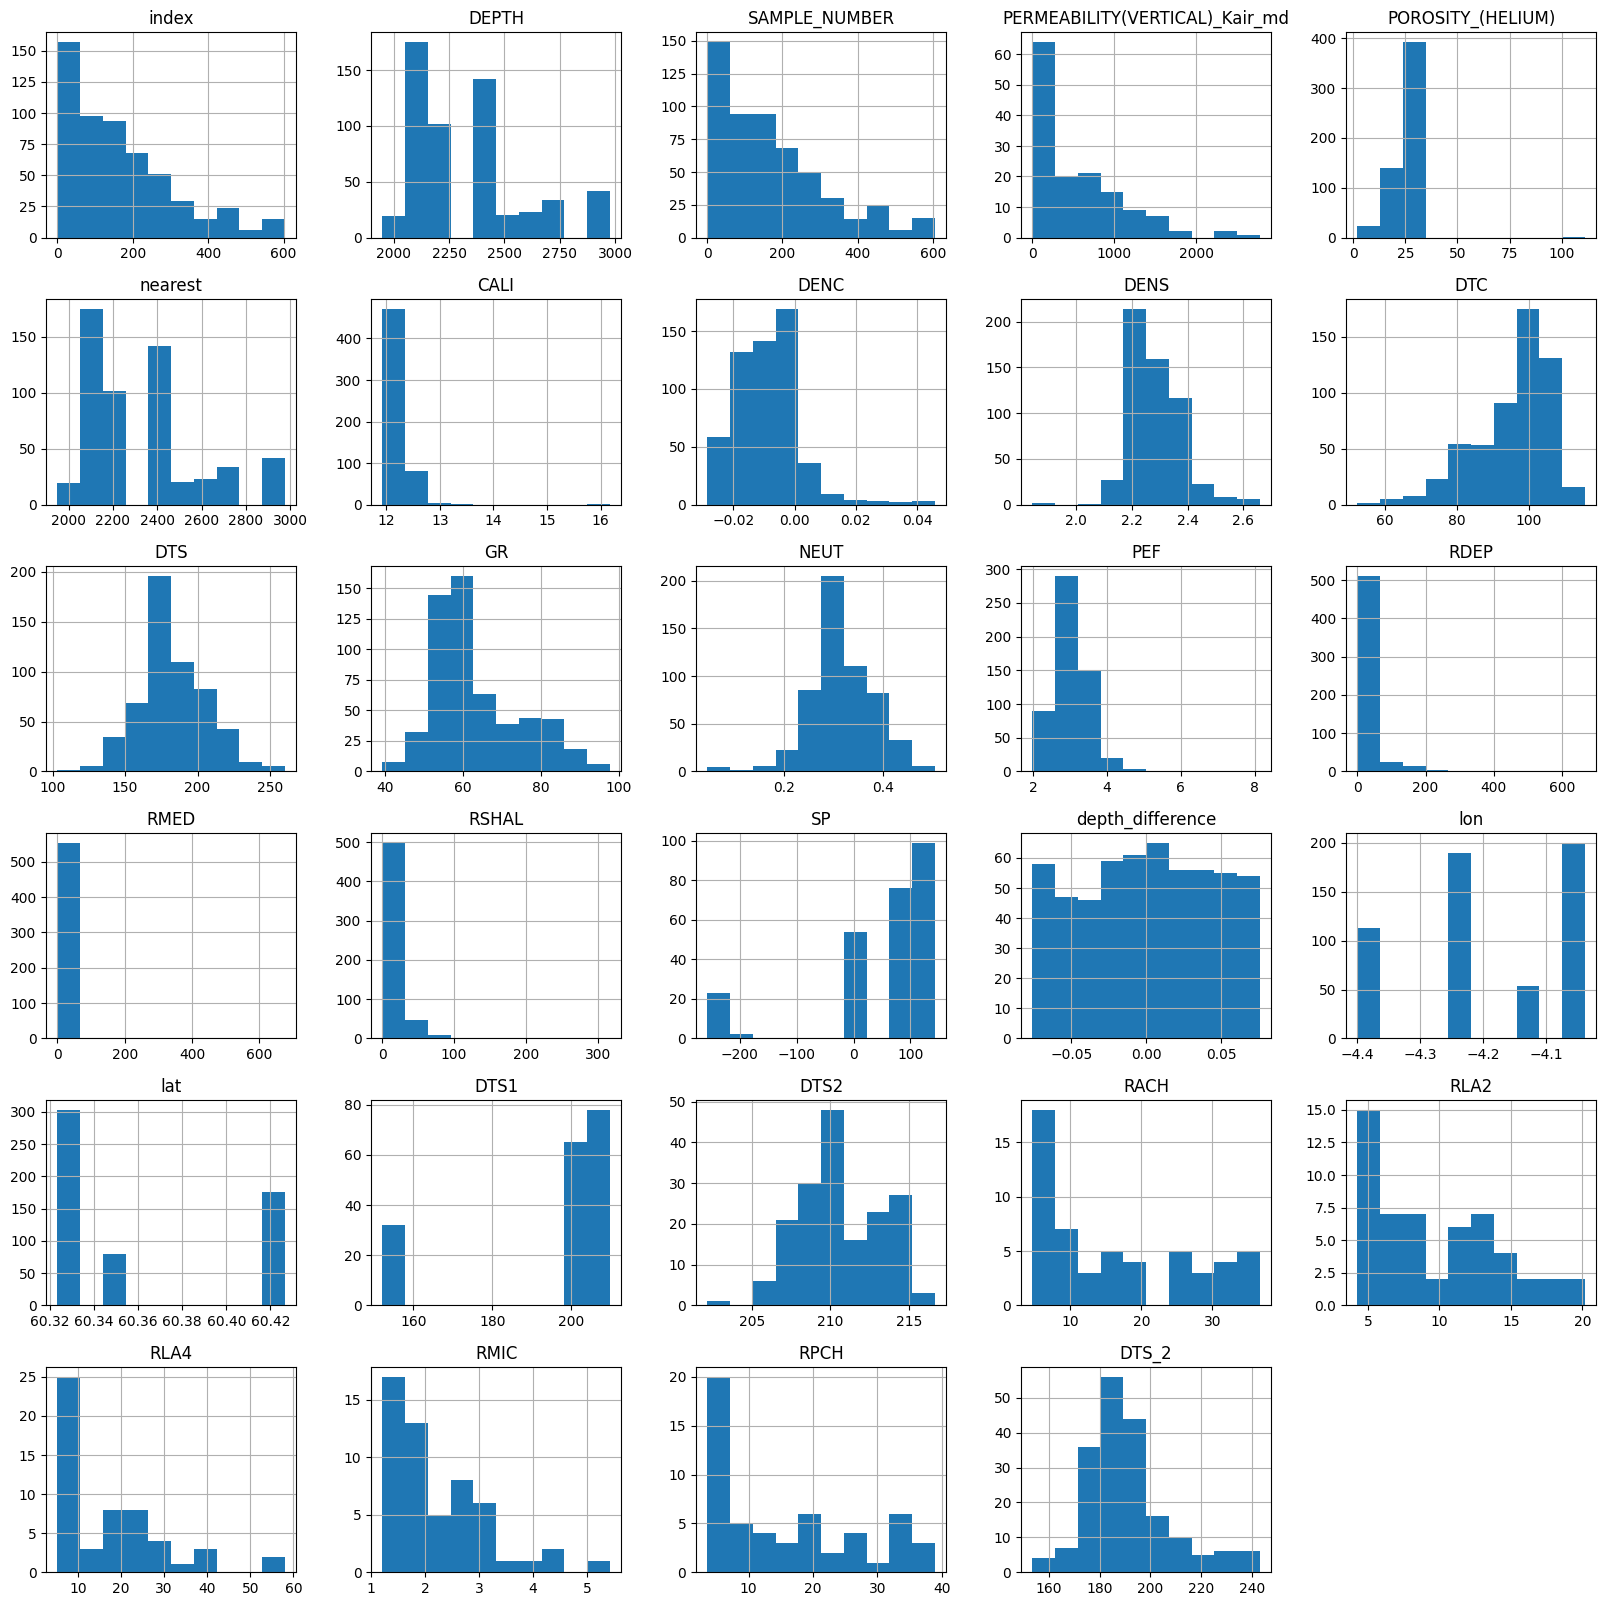

In [387]:
X_train.hist(figsize=(20,20));

### Observations:

We handle the skewness of data by applying log transform in our pipeline to boost the performance of regression models.

## Correlation analysis 

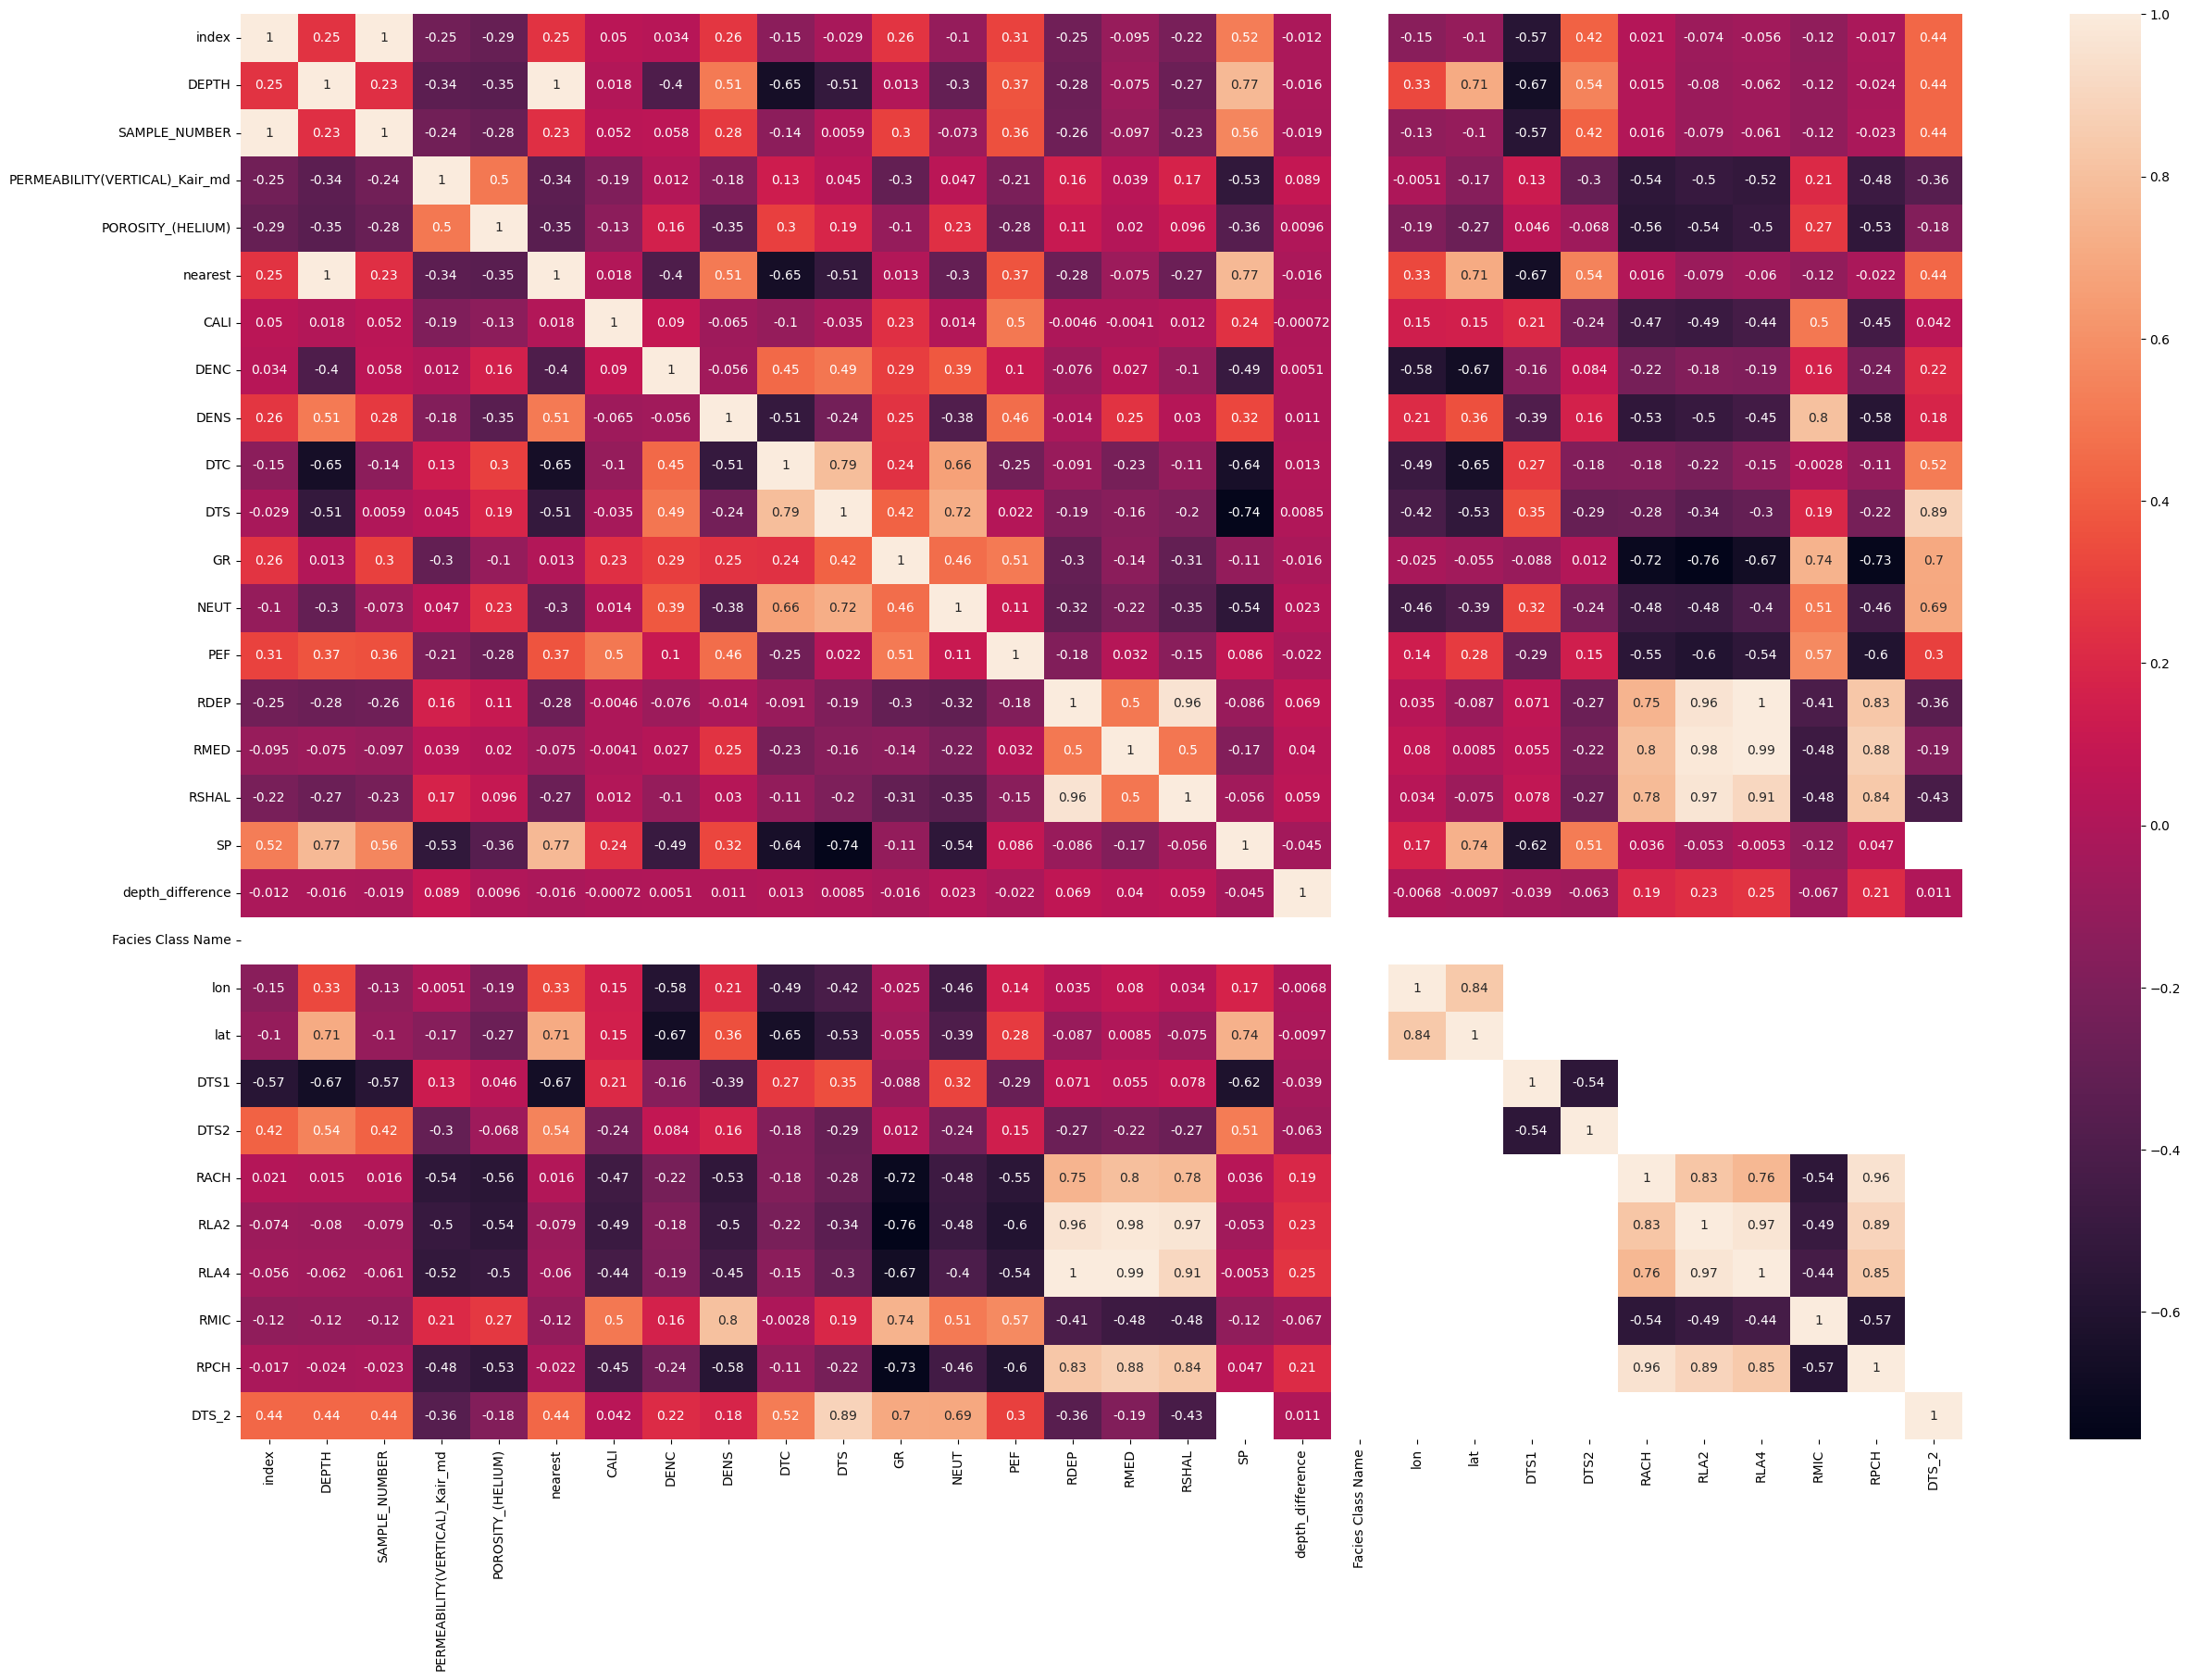

In [388]:
fig, ax = plt.subplots(1,1,figsize=(30, 20))

corr = X_train.apply(lambda x: pd.to_numeric(x, errors='coerce')).corr()

sns.heatmap(corr, annot=corr, ax=ax);

>> print the pairs of features with high correlation coefficient (threshold = 0.7)

>> Skip_list refers to those data that is either not being adopted in our model or we don't have sufficient data of these features for all the wells.

In [389]:
skip_list = ['DEPTH','index', 'SAMPLE_NUMBER', 'nearest', 'RACH', 'RLA2', 'RLA4', 'RPCH', 'lon', 'lat']
# Features that I don't consider to be useful for prediction

# Get pairs of features with correlation coefficient > 0.7
high_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.7:  # Adjust threshold as needed
            if (corr.columns[j] not in skip_list) and (corr.columns[i] not in skip_list):
                high_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

# Print high correlation pairs
for pair in high_corr_pairs:
    print(f"Features '{pair[0]}' and '{pair[1]}' : {round(pair[2], 2)}")

Features 'DENS' and 'RMIC' : 0.8
Features 'DTC' and 'DTS' : 0.79
Features 'DTS' and 'NEUT' : 0.72
Features 'DTS' and 'SP' : -0.74
Features 'DTS' and 'DTS_2' : 0.89
Features 'GR' and 'RMIC' : 0.74
Features 'RDEP' and 'RSHAL' : 0.96


## Observation:

RSHAL, RMED (= RMIC) , RDEP are inter-correlated and we decided to drop them to prevent multiple collinearity. All of them are resistivity log but at a different depth, so they may have some sort of relations by nature.

DTC and DTS are having very high correlation so we cannot deploy both in our model. We decided to perform FEATURE ENGINEERING before applying. We merge the 2 features into a single 1 by taking ratio between them. It makes geophysical sense by meaning the Vp/Vs ratio, which the ratio of velocity of Compresional wave to Shear wave implies:
(1) The presence of fluid (hydrocarbons)
(2) Elasticity 

## Construct Pipelines

In [410]:
cat_features = ['Facies Class Name']

to_log_features = ['CALI', 'GR', 'PEF', 'NEUT','RDEP', 'RMED', 'RSHAL', 'DENS']
no_log_features = ['POROSITY_(HELIUM)', 'SP']
VpVs_features = ['DTC', 'DTS']

num_features = to_log_features + no_log_features + VpVs_features
# num_features = ['CALI', 'DENS', 'DTC', 'DTS', 'GR', 'NEUT', 'PEF', 'RDEP', 'RMED', 'RSHAL', 'POROSITY_(HELIUM)']

SP_features = ['SP', 'Facies Class Name']

In [391]:
cat_features = ['Facies Class Name']

to_log_features = ['CALI','GR', 'PEF', 'NEUT', 'DENS']
no_log_features = ['POROSITY_(HELIUM)', 'SP']
VpVs_features = ['DTC', 'DTS']

num_features = to_log_features + no_log_features + VpVs_features

SP_features = ['SP', 'Facies Class Name']

In [411]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class VpVsRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['VpVsRatio'] = X_transformed['DTC'] / X_transformed['DTS']
        X_transformed.drop(['DTC', 'DTS'], axis=1, inplace=True)
        return X_transformed

class custom_imputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.group_medians_= []
        for i, feature in enumerate(num_features):
            self.group_medians_.append(X.groupby('Facies Class Name')[feature].median())
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for i, feature in enumerate(num_features):
            for category, median in self.group_medians_[i].items():
                X_transformed.loc[X_transformed['Facies Class Name'] == category, feature] \
                    = X_transformed.loc[X_transformed['Facies Class Name'] == category, feature].fillna(median)
            
        return X_transformed


class SP_imputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.group_medians_ = X.groupby('Facies Class Name')['SP'].median()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.dropna(subset=['Facies Class Name'], inplace=True)
        for category, median in self.group_medians_.items():
            X_transformed.loc[X_transformed['Facies Class Name'] == category, 'SP'] \
                = X_transformed.loc[X_transformed['Facies Class Name'] == category, 'SP'].fillna(median)
            
        return X_transformed

class SP_transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Drop rows with Facies Class Name = 'nc'or 'bc' (no cores or bad cores)
        # X_transformed = X_transformed.loc[~X_transformed['Facies Class Name'].isin(['nc', 'bc'])]

        # Transform both 'is' and 'ih'in Facies Class Name to combined class 'ms' (messy shale)
        X_transformed.loc[X_transformed['Facies Class Name'].isin(['is', 'ih']), 'Facies Class Name'] = 'ms'
        X_transformed.dropna(subset=['Facies Class Name'], inplace=True)

        return X_transformed

log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)

VpVsRatio_pipeline = Pipeline([
    ('VpVsRatio', VpVsRatioTransformer())
])

no_log_pipeline = ColumnTransformer([
    ('Other_no_log', "passthrough", no_log_features),
    ('VpVs_ratio', VpVsRatio_pipeline, VpVs_features)
])

numerical_transformer = ColumnTransformer([
    ('to_log', log_transformer, to_log_features),
    ('no_log', no_log_pipeline, no_log_features + VpVs_features)
])

numerical_pipeline = Pipeline([
    ('numerical_transformer', numerical_transformer),
    ('standard_scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

SP_transform_pipeline = Pipeline([
    ('SP_transformer', SP_transformer()),
    ('median_imputer', SP_imputer())
])

# SP_seperate_pipeline = ColumnTransformer([
#     ('StandardScaler', StandardScaler(), ['SP']),
#     ('categorical_transformer', categorical_transformer, cat_features)
# ])

# SP_pipeline = Pipeline([
#     ('SP_transform_pipeline', SP_transform_pipeline),
#     ('SP_seperate_pipeline', SP_seperate_pipeline)
# ])

combined_pipeline = ColumnTransformer([
    ('numerical_transformer', numerical_pipeline, num_features),
    ('categorical_transformer', categorical_transformer, cat_features)
], remainder='drop')

preprocessor = Pipeline([
    ('SP_transformer', SP_transformer()),
    ('custom_imputer', custom_imputer()),
    ('SP_imputer', SP_imputer()),
    ('combined_pipeline', combined_pipeline)
])

preprocessor


Pipeline(steps=[('SP_transformer', SP_transformer()),
                ('custom_imputer', custom_imputer()),
                ('SP_imputer', SP_imputer()),
                ('combined_pipeline',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('numerical_transformer',
                                                                   ColumnTransformer(transformers=[('to_log',
                                                                                                    FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                        inverse_func=<ufunc 'expm1'>,
                                                                                                                        valid...
                                                                                                                                     Pipeline(steps=[('VpVsRatio',
                                                                                                                                                      VpVsRatioTransformer())]),
                                                                                                                                     ['DTC',
                                                                                                                                      'DTS'])]),
                                                                                                    ['POROSITY_(HELIUM)',
                                                                                                     'SP',
                                                                                                     'DTC',
                                                                                                     'DTS'])])),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['CALI', 'GR', 'PEF', 'NEUT',
                                                   'RDEP', 'RMED', 'RSHAL',
                                                   'DENS', 'POROSITY_(HELIUM)',
                                                   'SP', 'DTC', 'DTS']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Facies Class Name'])]))])

In [320]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_train_prepared.shape

/Users/hadrianfung/miniconda3/envs/GEMS1B/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


(563, 12)

In [ ]:
X_all = pd.concat([X_train, X_val, X_test])

## Random Forest RF

In [672]:
from sklearn.ensemble import RandomForestRegressor

full_pipeline_RF = Pipeline([
    ('preproccessing_pipeline', preprocessor),
    ('rf', RandomForestRegressor(bootstrap=True, n_estimators=22, max_depth=13, max_features='sqrt', min_samples_leaf=2, min_samples_split=10,
                                 random_state=42, n_jobs=-1))
])
full_pipeline_RF.fit(X_train,y_train);

/Users/hadrianfung/miniconda3/envs/GEMS1B/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


In [673]:
from sklearn.metrics import r2_score

r2 = r2_score(y_train, full_pipeline_RF.predict(X_train))

print(f'R-squared (R²): {r2}')

R-squared (R²): 0.8111838143153206


In [674]:
r2 = r2_score(y_test, full_pipeline_RF.predict(X_test))

print(f'R-squared (R²): {r2}')

R-squared (R²): 0.6293909185894739


In [675]:
r2 = r2_score(y_val, full_pipeline_RF.predict(X_val))

print(f'R-squared (R²): {r2}')

R-squared (R²): 0.31959254032927065


In [676]:
pickle.dump(full_pipeline_RF, open('../geointerpreter/models/perm_model_RF.pkl', 'wb'))

In [710]:
X_total = pd.concat((X_train, X_val, X_test))
y_total = np.concatenate((y_train, y_val, y_test))

full_pipeline_RF.fit(X_total,y_total)

pickle.dump(full_pipeline_RF, open('../geointerpreter/models/perm_model_RF.pkl', 'wb'))

/Users/hadrianfung/miniconda3/envs/GEMS1B/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


## SVR

In [677]:
from sklearn.svm import SVR

full_pipeline_SVR = Pipeline([
    ('preproccessing_pipeline', preprocessor),
    ('svr', SVR(kernel='rbf', C=175))
])

In [678]:
full_pipeline_SVR.fit(X_train,y_train)
r2 = r2_score(y_train, full_pipeline_SVR.predict(X_train))

print(f'R-squared (R²): {r2}')

R-squared (R²): 0.519751631696465


/Users/hadrianfung/miniconda3/envs/GEMS1B/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


In [679]:
r2 = r2_score(y_test, full_pipeline_SVR.predict(X_test))

print(f'R-squared (R²): {r2}')

R-squared (R²): 0.4417443740394149


In [707]:
pickle.dump(full_pipeline_SVR, open('../geointerpreter/models/perm_model_SVR.pkl', 'wb'))

In [711]:
full_pipeline_SVR.fit(X_total,y_total)

pickle.dump(full_pipeline_SVR, open('../geointerpreter/models/perm_model_SVR.pkl', 'wb'))

/Users/hadrianfung/miniconda3/envs/GEMS1B/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


## XGBoost

In [681]:
from xgboost import XGBRegressor
full_pipeline_GBR = Pipeline([
    ('preproccessing_pipeline', preprocessor),
    ('xgb', XGBRegressor(learning_rate=0.01, n_estimators=120, max_depth=30, min_child_weight=2, gamma=.1, subsample=0.8))
])
full_pipeline_GBR.fit(X_train,y_train)

/Users/hadrianfung/miniconda3/envs/GEMS1B/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Pipeline(steps=[('preproccessing_pipeline',
                 Pipeline(steps=[('SP_transformer', SP_transformer()),
                                 ('custom_imputer', custom_imputer()),
                                 ('SP_imputer', SP_imputer()),
                                 ('combined_pipeline',
                                  ColumnTransformer(transformers=[('numerical_transformer',
                                                                   Pipeline(steps=[('numerical_transformer',
                                                                                    ColumnTransformer(transformers=[('to_log',
                                                                                                                     FunctionTransformer(func=<ufun...
                              feature_types=None, gamma=0.1, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=30, max_leaves=None, min_child_weight=2,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=120,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [682]:
r2 = r2_score(y_train, full_pipeline_GBR.predict(X_train))

print(f'R-squared (R²): {r2}')

R-squared (R²): 0.8149699430201427


In [683]:
r2 = r2_score(y_test, full_pipeline_GBR.predict(X_test))

print(f'R-squared (R²): {r2}')

R-squared (R²): 0.5806263941691744


In [684]:
r2 = r2_score(y_val, full_pipeline_GBR.predict(X_val))

print(f'R-squared (R²): {r2}')

R-squared (R²): 0.4605771682933648


In [714]:
pickle.dump(full_pipeline_GBR, open('../geointerpreter/models/perm_model_XGB.pkl', 'wb'))

In [715]:
full_pipeline_GBR.fit(X_total,y_total)

pickle.dump(full_pipeline_GBR, open('../geointerpreter/models/perm_model_XGB.pkl', 'wb'))

/Users/hadrianfung/miniconda3/envs/GEMS1B/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
